# Sprint 3

## Intro

### Idea 1 (Tim)
>> explain 



In [ ]:
# code Tim

### Idea 2 and why this
tekst + company = product
- neural netw
- productie
- Can you find complaints that are assigned to the wrong category? 

## Data (Lennart)

> todo

In [ ]:
# downloads and installs
import sys

!conda install --yes --prefix {sys.prefix} nltk bs4 gensim
import nltk
nltk.download('stopwords')

In [ ]:
!conda update --yes --prefix {sys.prefix} -n base conda

In [ ]:
!conda install -c anaconda --yes --update-deps gensim

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import multiprocessing
from gensim.sklearn_api import D2VTransformer

from sklearn.model_selection import train_test_split

In [ ]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

In [86]:
# Basic constants
SAMPLE_AMOUNT = 50000
VISUAL_AMOUNT = 5000
PRODUCT_AMOUNT = len(set(complaints['Product']))

## EDA (Lennart)

> todo

## PreProcessing (Lennart)

handmatig
> Hoe met tensorflow? (TIM)

### Sampling

In [87]:
data = complaints.sample(SAMPLE_AMOUNT, random_state=7844569)

### Cleaning

In [88]:
def preprocessing(text):
    stopWords = stopWords = set(stopwords.words('english'))
    stemmer = SnowballStemmer("english")
    
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [89]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

### One-Hot encoding company names

In [142]:
companies_1he = pd.get_dummies(data['Company'])

### Feature extraction customer complaint narative

In [91]:
def doc2vec():
    listOfDocsAsListOfStrings = [doc for doc in (row.split() for row in data['Consumer complaint narrative'])]
    model = D2VTransformer(size=250, window=5, min_count=2, workers=multiprocessing.cpu_count())
    transformed = model.fit_transform(listOfDocsAsListOfStrings)
    return transformed

In [92]:
transformed = doc2vec()

In [147]:
print(transformed.shape)
print(companies_1he.shape)
#test = np.concatenate(transformed,companies_1he.to_numpy(), axis=1)
#x = np.append(transformed, companies_1he.to_numpy(),axis=1)
#x.shape

(50000, 250)
(50000, 2149)


### create sets

delegated to model creation to check if different datasets yield better results

In [148]:
def createDataSets(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

    return x_train,x_val,x_test,y_train,y_val,y_test

targets_1he = pd.get_dummies(data['Product'])


y = targets_1he

# x = to be defined by model

#x = np.append(transformed, companies_1he.to_numpy(),axis=1)
#x = transformed
#x = pd.concat([data['Consumer complaint narrative'], companies_1he], axis=1)
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [149]:
print(x_train.shape)
print(y_train.shape)

(31500, 250)
(31500, 17)


## Premade estimator?  OR PoC in KERAS -> Customer Estimator (Roel)

> todo

In [160]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

In [172]:
def createModel(optimizer,loss, input_shape, output_shape):
    
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_shape[1],)))
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(output_shape[1], activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) # optimizer='adam'
    return model

def trainModel(model, x, y, batch_size=64, epochs=10):
    x_train,x_val,x_test,y_train,y_val,y_test = createDataSets(x,y)
    
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, y_val))
    return history, x_test,y_test
    

def validateModel(history, score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Check how good a standard model performs with just the doc2vec set

Epoch 1/10
493/493 [==============================] - 2s 3ms/step - loss: 1.8726 - accuracy: 0.4231 - val_loss: 1.4727 - val_accuracy: 0.5609
Epoch 2/10
493/493 [==============================] - 1s 3ms/step - loss: 1.3664 - accuracy: 0.5770 - val_loss: 1.2780 - val_accuracy: 0.6054
Epoch 3/10
493/493 [==============================] - 2s 4ms/step - loss: 1.2483 - accuracy: 0.6027 - val_loss: 1.2198 - val_accuracy: 0.6100
Epoch 4/10
493/493 [==============================] - 1s 3ms/step - loss: 1.1966 - accuracy: 0.6113 - val_loss: 1.1938 - val_accuracy: 0.6143
Epoch 5/10
493/493 [==============================] - 1s 3ms/step - loss: 1.1620 - accuracy: 0.6206 - val_loss: 1.1875 - val_accuracy: 0.6197
Epoch 6/10
493/493 [==============================] - 1s 3ms/step - loss: 1.1402 - accuracy: 0.6255 - val_loss: 1.1558 - val_accuracy: 0.6249
Epoch 7/10
493/493 [==============================] - 1s 3ms/step - loss: 1.1165 - accuracy: 0.6314 - val_loss: 1.1448 - val_accuracy: 0.6246
Epoch 

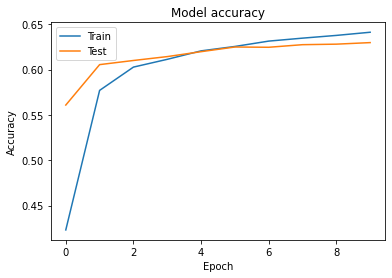

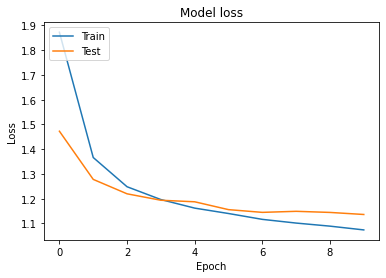

In [173]:
x = transformed

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape, y.shape)

history,x_test,y_test = trainModel(model,x,y)

score = model.evaluate(x_test, y_test, verbose=0)
validateModel(history,score)

Check how good a standard model performs when adding company names

In [175]:
x = np.append(transformed, companies_1he.to_numpy(),axis=1)
print(x.shape)
print(y.shape)

(50000, 2399)
(50000, 17)


Epoch 1/10
493/493 [==============================] - 3s 6ms/step - loss: 1.6039 - accuracy: 0.5139 - val_loss: 1.1510 - val_accuracy: 0.6320
Epoch 2/10
493/493 [==============================] - 3s 5ms/step - loss: 1.0254 - accuracy: 0.6673 - val_loss: 0.9837 - val_accuracy: 0.6766
Epoch 3/10
493/493 [==============================] - 3s 5ms/step - loss: 0.9147 - accuracy: 0.6936 - val_loss: 0.9331 - val_accuracy: 0.6926
Epoch 4/10
493/493 [==============================] - 3s 6ms/step - loss: 0.8634 - accuracy: 0.7043 - val_loss: 0.9031 - val_accuracy: 0.6997
Epoch 5/10
493/493 [==============================] - 3s 5ms/step - loss: 0.8297 - accuracy: 0.7117 - val_loss: 0.8915 - val_accuracy: 0.6994
Epoch 6/10
493/493 [==============================] - 3s 6ms/step - loss: 0.8037 - accuracy: 0.7196 - val_loss: 0.8782 - val_accuracy: 0.7020
Epoch 7/10
493/493 [==============================] - 3s 6ms/step - loss: 0.7838 - accuracy: 0.7251 - val_loss: 0.8629 - val_accuracy: 0.7040
Epoch 

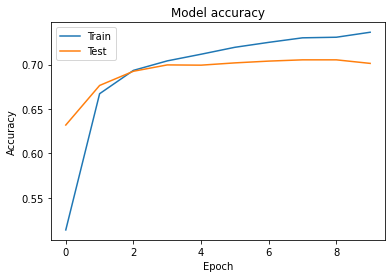

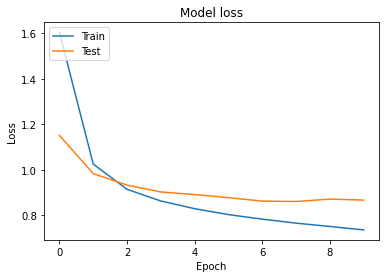

In [176]:
#keras.backend.clear_session()

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

TODO: add more data / process data differently to see if it has an influence on NN

## Vertalen PoC naar tf.estimator

## In productie (TIM)

> todo

## Can you find complaints that are assigned to the wrong category? (EDA)

> todo